In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model


In [2]:
(x_train, _), (x_test, _) = fashion_mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
print("x_train shape:", x_train.shape)
print("x_test shape:", x_test.shape)

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
x_train shape: (60000, 28, 28)
x_test shape: (10000, 28, 28)


In [4]:
latent_dim = 64
class Autoencoder(Model):
    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()
        self.encoder = tf.keras.Sequential([
            layers.Flatten(),
            layers.Dense(latent_dim, activation='relu'),
        ])
        self.decoder = tf.keras.Sequential([
            layers.Dense(784, activation='sigmoid'),
            layers.Reshape((28, 28))
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

autoencoder = Autoencoder(latent_dim)
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [5]:
autoencoder.fit(x_train, x_train, epochs=10, shuffle=True, validation_data=(x_test, x_test))


Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0400 - val_loss: 0.0134
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.0124 - val_loss: 0.0107
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0104 - val_loss: 0.0098
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.0097 - val_loss: 0.0095
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0093 - val_loss: 0.0092
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 0.0091 - val_loss: 0.0091
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.0090 - val_loss: 0.0090
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - loss: 0.0090 - val_loss: 0.0090
Epoch 9/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 21s 6ms/step - loss: 0.0088 - val_loss: 0.0089
Epoch 10/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - loss: 0.0088 - val_loss: 0.0090


In [6]:
encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

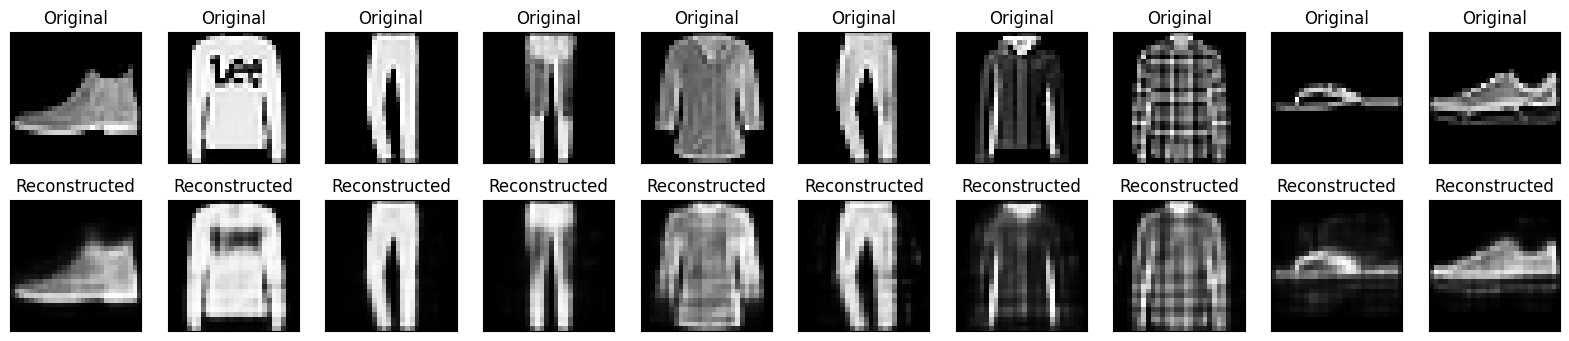

In [7]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # Original images
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i])
    plt.title("Original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Reconstructed images
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i])
    plt.title("Reconstructed")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


In [8]:
dataframe = pd.read_csv('http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv', header=None)
raw_data = dataframe.values

In [13]:
labels = raw_data[:, -1]
data = raw_data[:, 0:-1]
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.2, random_state=21)

# Normalize data
min_val = tf.reduce_min(train_data)
max_val = tf.reduce_max(train_data)

train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)
train_data, test_data = tf.cast(train_data, tf.float32), tf.cast(test_data, tf.float32)
train_labels, test_labels = train_labels.astype(bool), test_labels.astype(bool)

# Separate normal and anomalous ECGs
normal_train_data, normal_test_data = train_data[train_labels], test_data[test_labels]
anomalous_train_data, anomalous_test_data = train_data[~train_labels], test_data[~test_labels]


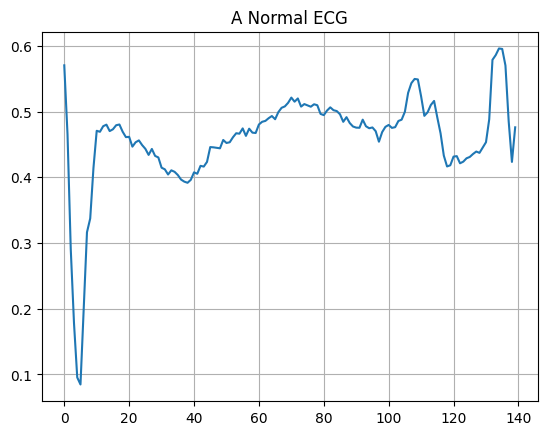

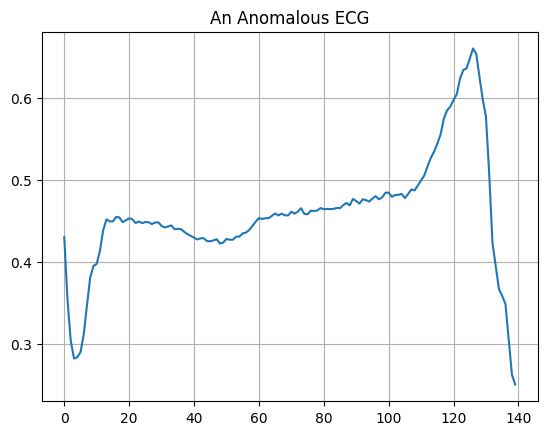

In [14]:
plt.plot(np.arange(140), normal_train_data[0])
plt.title("A Normal ECG")
plt.grid()
plt.show()

plt.plot(np.arange(140), anomalous_train_data[0])
plt.title("An Anomalous ECG")
plt.grid()
plt.show()

In [15]:
class AnomalyDetector(Model):
    def __init__(self):
        super(AnomalyDetector, self).__init__()
        self.encoder = tf.keras.Sequential([
            layers.Dense(32, activation="relu"),
            layers.Dense(16, activation="relu"),
            layers.Dense(8, activation="relu")
        ])
        self.decoder = tf.keras.Sequential([
            layers.Dense(16, activation="relu"),
            layers.Dense(32, activation="relu"),
            layers.Dense(140, activation="sigmoid")
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

autoencoder = AnomalyDetector()
autoencoder.compile(optimizer='adam', loss='mae')

In [16]:
history = autoencoder.fit(normal_train_data, normal_train_data, epochs=20, batch_size=512, validation_data=(test_data, test_data), shuffle=True)

Epoch 1/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 0.0590 - val_loss: 0.0535
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0566 - val_loss: 0.0523
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0547 - val_loss: 0.0509
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0521 - val_loss: 0.0500
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0492 - val_loss: 0.0480
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0455 - val_loss: 0.0459
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0417 - val_loss: 0.0444
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0380 - val_loss: 0.0421
Epoch 9/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0346 - val_loss: 0.0408
Epoch 10/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0322 - val_loss: 0.0393
Epoch 11/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0297 - val_loss: 0.0384
Epoch 12/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0282 - val_loss: 0.0376
Epo

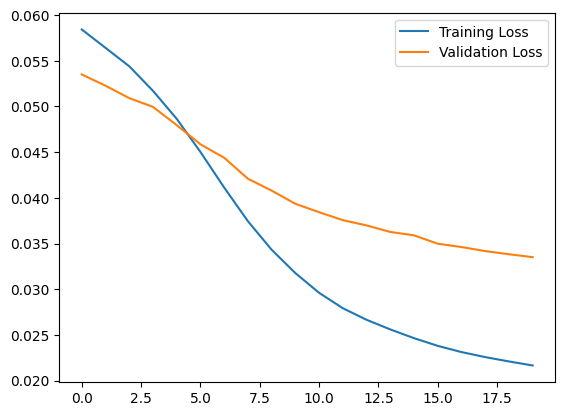

In [17]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()


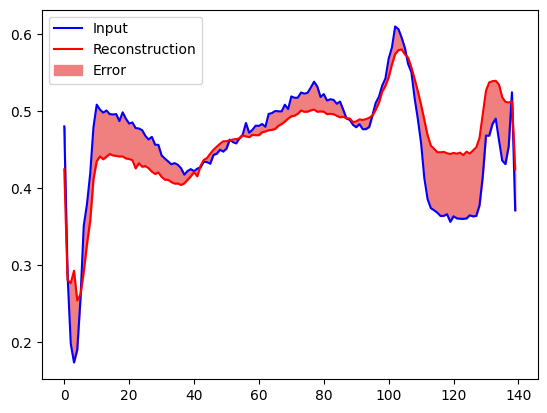

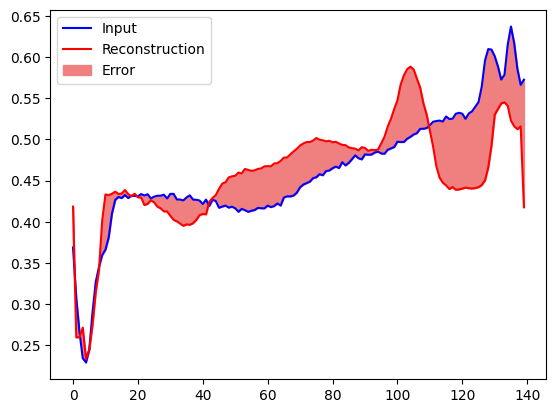

In [18]:
encoded_data = autoencoder.encoder(normal_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()
plt.plot(normal_test_data[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(140), decoded_data[0], normal_test_data[0], color='lightcoral')
plt.legend(["Input", "Reconstruction", "Error"])
plt.show()

encoded_data = autoencoder.encoder(anomalous_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()
plt.plot(anomalous_test_data[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(140), decoded_data[0], anomalous_test_data[0], color='lightcoral')
plt.legend(["Input", "Reconstruction", "Error"])
plt.show()

74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


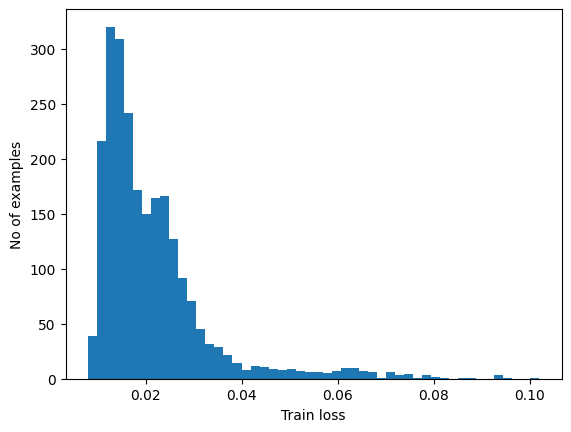

In [19]:
reconstructions = autoencoder.predict(normal_train_data)
train_loss = tf.keras.losses.mae(reconstructions, normal_train_data)
plt.hist(train_loss[None, :], bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

In [20]:
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold:", threshold)

Threshold: 0.033363175


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


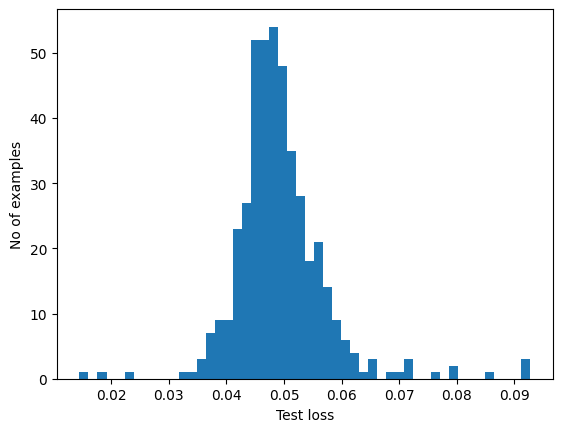

In [21]:
reconstructions = autoencoder.predict(anomalous_test_data)
test_loss = tf.keras.losses.mae(reconstructions, anomalous_test_data)
plt.hist(test_loss[None, :], bins=50)
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.show()

In [22]:
def predict(model, data, threshold):
    reconstructions = model(data)
    loss = tf.keras.losses.mae(reconstructions, data)
    return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
    print("Accuracy = {}".format(accuracy_score(labels, predictions)))
    print("Precision = {}".format(precision_score(labels, predictions)))
    print("Recall = {}".format(recall_score(labels, predictions)))

In [23]:
preds = predict(autoencoder, train_data, threshold)
print_stats(preds, train_labels)

preds = predict(autoencoder, test_data, threshold)
print_stats(preds, test_labels)

Accuracy = 0.9379689844922461
Precision = 0.9902461681374826
Recall = 0.9037727850784231
Accuracy = 0.944
Precision = 0.9921875
Recall = 0.9071428571428571
